<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/DL_AE_MNIST_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
47/47 - 25s - 530ms/step - loss: 0.2988 - val_loss: 0.1247
Epoch 2/20
47/47 - 17s - 365ms/step - loss: 0.1133 - val_loss: 0.1038
Epoch 3/20
47/47 - 22s - 462ms/step - loss: 0.0999 - val_loss: 0.0940
Epoch 4/20
47/47 - 19s - 409ms/step - loss: 0.0949 - val_loss: 0.0924
Epoch 5/20
47/47 - 23s - 484ms/step - loss: 0.0926 - val_loss: 0.0895
Epoch 6/20
47/47 - 17s - 367ms/step - loss: 0.0907 - val_loss: 0.0884
Epoch 7/20
47/47 - 17s - 367ms/step - loss: 0.0896 - val_loss: 0.0871
Epoch 8/20
47/47 - 20s - 435ms/step - loss: 0.0885 - val_loss: 0.0870
Epoch 9/20
47/47 - 31s - 660ms/step - loss: 0.0877 - val_loss: 0.0855
Epoch 10/20
47/47 - 31s - 660ms/step - loss: 0.0873 - val_loss: 0.0849
Epoch 11/20
47/47 - 20s - 425ms/step - loss: 0.0863 - val_loss: 0.0845
Epoch 12/20
47/47 - 21s - 454ms/step - loss: 0.0862 - val_loss: 0.0840
Epoch 13/20
47/47 - 21s - 448ms/step - loss: 0.0853 - val_loss: 0.0841
Epoch 14/20
47/47 - 20s - 424ms/ste

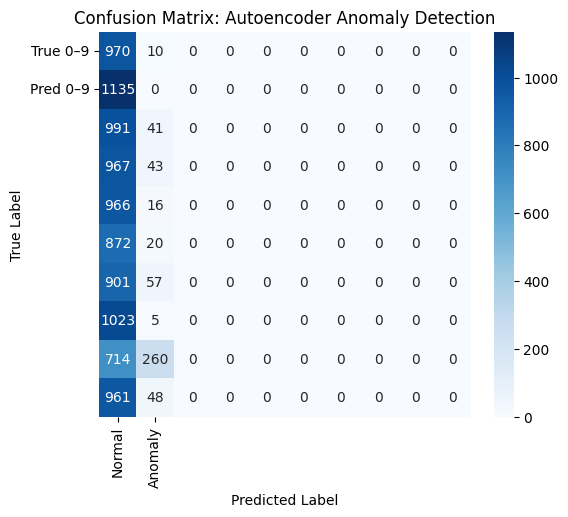

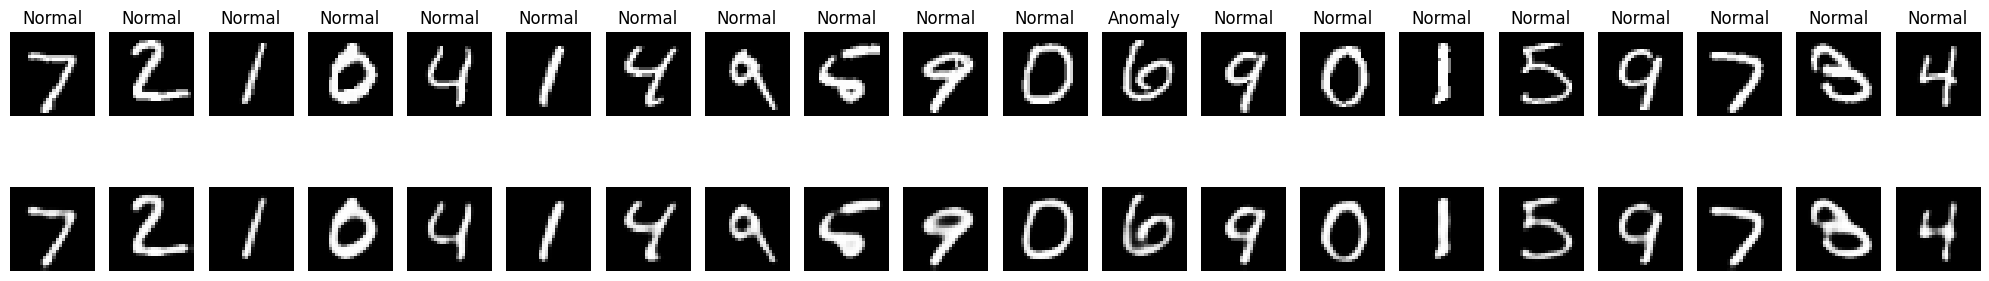

In [ ]:
import numpy as np                                # Numerical computing library
import matplotlib.pyplot as plt                   # Plotting library
import tensorflow as tf                           # TensorFlow backend
from tensorflow.keras import layers, models       # Keras layers & model API
from tensorflow.keras.datasets import mnist       # MNIST dataset loader
from sklearn.metrics import confusion_matrix       # Confusion matrix for evaluation
import seaborn as sns                             # Seaborn for nicer heatmaps

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load the MNIST dataset (handwritten digits 0–9)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 2. Normalize pixel values to [0,1] and reshape to (28,28,1) for Conv2D
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # shape becomes (60000,28,28,1)
x_test  = np.expand_dims(x_test,  axis=-1)  # shape becomes (10000,28,28,1)

# 3. Keep only digit '0' images for training (normal class)
x_train_normal = x_train[y_train == 0]  # ~6000 samples of the digit 0
x_test_normal  = x_test[y_test   == 0]  # ~1000 samples of the digit 0 (for validation)

# 4. Build the convolutional autoencoder architecture
input_img = layers.Input(shape=(28, 28, 1))      # Input placeholder

# Encoder network: compresses to a low-dimensional representation
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)       # Downsample to 14×14×32
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x) # Downsample to 7×7×64

# Decoder network: reconstructs back to the original image dimensions
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)                        # Upsample to 14×14×64
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                        # Upsample to 28×28×32
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# 5. Instantiate & compile the autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 6. Train only on the “normal” class (digit 0)
#    We use the same data as both input and target
autoencoder.fit(
    x_train_normal, x_train_normal,
    epochs=20,                  # number of full passes through the data
    batch_size=128,             # number of samples per gradient update
    validation_data=(x_test_normal, x_test_normal),
    verbose=2                   # print training progress
)

# 7. Use the trained autoencoder to reconstruct all test images
decoded_imgs = autoencoder.predict(x_test)

# 8. Compute reconstruction error per image (mean absolute pixel difference)
reconstruction_errors = np.mean(
    np.abs(decoded_imgs - x_test),
    axis=(1, 2, 3)              # average over height, width, channels
)

# 9. Choose an anomaly threshold at the 95th percentile of errors
threshold = np.percentile(reconstruction_errors, 95)

# 10. Predict anomalies: label 1 if error > threshold, else 0
y_pred = (reconstruction_errors > threshold).astype(int)

# 11. Evaluate performance with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal','Anomaly'],
    yticklabels=['True 0–9','Pred 0–9']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Autoencoder Anomaly Detection')
plt.show()

# 12. Visualize a few test images with their reconstruction and labels
n = 20  # number of examples to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    title = 'Anomaly' if y_pred[i] else 'Normal'
    plt.title(title)
    ax.axis('off')

    # Reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
